In [115]:
#####Factorization meets the item Embedding#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

(array([  4.,   8.,  76., 192., 320., 504., 583., 628., 641., 559., 424.,
        323., 249., 152., 120.,  78.,  61.,  32.,  20.,   6.,   9.,   4.,
          5.,   1.,   1.]),
 array([ 13.  ,  23.12,  33.24,  43.36,  53.48,  63.6 ,  73.72,  83.84,
         93.96, 104.08, 114.2 , 124.32, 134.44, 144.56, 154.68, 164.8 ,
        174.92, 185.04, 195.16, 205.28, 215.4 , 225.52, 235.64, 245.76,
        255.88, 266.  ]),
 <a list of 25 Patch objects>)

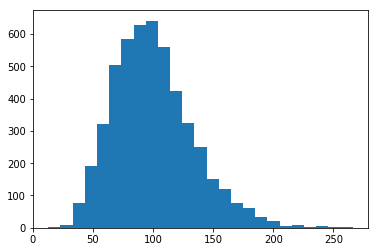

In [116]:
####データの生成####
##データの設定
s = 2
k = 10
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.1, hh), hh)
hhpt = np.sum(pt)
plt.hist(pt, bins=25)

In [117]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = index[d_id==i]
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [118]:
#素性ベクトルを生成
k1 = 5; k2 = 6; k3 = 5
x1 = np.abs(np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1)))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)   #すべての説明変数を結合
x_col = x.shape[1]

In [119]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.225, item), topic)
theta = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[d_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

#アイテムのインデックスを作成
item_list = [j for j in range(item)]
for j in range(item):
    item_list[j] = np.array(np.where(item_id==j)[0], dtype="int")

0
1000
2000
3000
4000


In [120]:
##応答変数を生成
rp = 0
while True:
    rp = 0

    ##モデルパラメータを生成
    #事前分布のパラメータ
    alpha_u = np.repeat(0, k)
    alpha_v = np.repeat(0, k)
    tau = np.array([1.5])
    Cov_u = np.diag(np.repeat(0.5, k))
    Cov_v1 = np.diag(np.repeat(0.5, k))
    Cov_v2 = np.diag(np.repeat(0.5, k))
    alpha_ut = alpha_u.copy(); alpha_vt = alpha_v.copy()
    taut = tau.copy(); Cov_ut = Cov_u.copy(); Cov_vt1 = Cov_v1.copy(); Cov_vt2 = Cov_v2.copy()
    
    #MFのパラメータを生成
    beta = np.append(-1.0, np.random.normal(0, 0.7, x_col-1))
    theta = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    Sigma = np.array([1.0])
    betat = beta.copy(); thetat = theta.copy(); Sigmat = Sigma.copy()

    #item embeddingのパラメータ
    alpha = np.random.normal(-0.3, tau, item)
    gamma = np.random.multivariate_normal(np.repeat(0, k), Cov_v1, hh)
    omega = np.random.multivariate_normal(np.repeat(0, k), Cov_v2, hh)
    alphat = alpha.copy(); gammat = gamma.copy(); omegat = omega.copy()

    ##アイテム購買応答変数を生成
    #期待値を設定
    mu1 = np.dot(x, beta) + np.sum(theta[d_id, ] * gamma[item_id, ], axis=1)

    #正規分布からバイナリー変数を生成
    u1 = np.random.normal(mu1, Sigma, hhpt)
    y1 = np.array(u1 > 0, dtype="int")
    y_vec1 = y1[:, np.newaxis]
    
    #break条件
    print(np.mean(y1))
    if (np.mean(y1) > 0.2) & (np.mean(y1) < 0.4):
        break

0.19758877291115218
0.020098886280777106
0.09543824601708036
0.14574439394696098
0.2712240922938621


In [121]:
##item Embeddingの応答変数を生成
#データの設定
n = 5
no = np.arange(item)
rate = item_n / np.sum(item_n)
y2_list = [j for j in range(item)]
Embedding_id_list1 = [j for j in range(item)]
Embedding_id_list2 = [j for j in range(item)]

#アイテムの共起関係を生成
for j in range(item):
    if j%1000==0:
        print(j)
    random_id = np.random.choice(no, item*n, p=rate)
    mu2 = alpha[j] + alpha[random_id] + np.sum(gamma[np.repeat(j, item*n), ] * omega[random_id, ], axis=1)
    u2 = np.random.normal(mu2, Sigma, item*n)
    y2 = np.array(u2 > 0, dtype="int")
 
    #負例サンプリングでアイテムを生成
    index_y1 = np.array(np.where(y2==1)[0], dtype="int")
    index_y0 = np.array(np.where(y2==0)[0], dtype="int")
    y2_list[j] = np.append(np.repeat(1, item_n[j]), np.repeat(0, item_n[j]*s))
    Embedding_id_list1[j] = np.repeat(j, y2_list[j].shape[0])
    Embedding_id_list2[j] = np.append(random_id[np.random.choice(index_y1, item_n[j], replace=True)], 
                                      random_id[np.random.choice(index_y0, item_n[j]*s, replace=True)])

0
1000
2000


In [122]:
#リストを変換
Embedding_id1 = np.array(list(itertools.chain(*[Embedding_id_list1[j] for j in range(item)])))
Embedding_id2 = np.array(list(itertools.chain(*[Embedding_id_list2[j] for j in range(item)])))
y2 = np.array(list(itertools.chain(*[y2_list[j] for j in range(item)])))
N = y2.shape[0]
del Embedding_id_list1, Embedding_id_list2, y2_list

In [123]:
#Embeddingのインデックスを設定
Embedding_list1 = [j for j in range(item)]
Embedding_list2 = [j for j in range(item)]
for j in range(item):
    Embedding_list1[j] = np.array(np.where(Embedding_id1==j)[0], dtype="int")
    Embedding_list2[j] = np.array(np.where(Embedding_id2==j)[0], dtype="int")

In [124]:
##テストデータの生成



In [125]:
####ギブスサンプリングでFactorization meets the item Embeddingを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [126]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 2000
keep = 2  
iter = 0
burnin = 500/keep
disp = 10

In [127]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s0 = 0.1
v0 = 0.1

#素性ベクトルの事前分布
Lambda = np.repeat(0, x_col) 
kappa = np.diag(np.repeat(100, x_col))
inv_kappa = np.linalg.inv(kappa)

In [186]:
##パラメータの真値
#階層モデルの事前分布の真値
alpha_u = alpha_ut.copy()
alpha_v = alpha_vt.copy()
tau = taut.copy()
Cov_u = Cov_ut.copy()
Cov_v1 = Cov_vt1.copy()
Cov_v2 = Cov_vt2.copy()
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの真値
beta = betat.copy()
theta = thetat.copy()
Sigma = np.array([1.0])
beta_mu = np.dot(x, beta)
uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)

#item embeddingのパラメータの真値
alpha1 = alphat.copy()
alpha2 = alphat.copy()
gamma = gammat.copy()
omega = omegat.copy()
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)

In [129]:
##パラメータの初期値
#階層モデルの事前分布の初期値
alpha_u = np.repeat(0, k)
alpha_v = np.repeat(0, k)
tau = np.array([1.0])
Cov_u = np.diag(np.repeat(1.0, k))
Cov_v1 = np.diag(np.repeat(1.0, k))
Cov_v2 = np.diag(np.repeat(1.0, k))
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v1 = np.linalg.inv(Cov_v1)
inv_Cov_v2 = np.linalg.inv(Cov_v2)

#MFのパラメータの初期値
beta = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y1)
theta = np.random.multivariate_normal(alpha_u, np.diag(np.repeat(0.1, k), hh)
Sigma = np.array([1.0])
beta_mu = np.dot(x, beta)
uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)

#item embeddingのパラメータの初期値
alpha1 = np.random.normal(0, 0.5, item)
alpha2 = np.random.normal(0, 0.5, item)
gamma = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k), hh)
omega = np.random.multivariate_normal(alpha_v, np.diag(np.repeat(0.1, k), hh)
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)

In [169]:
##データの設定
#データの定数
XXV = np.dot(x.T, x) + inv_kappa
inv_XXV = np.linalg.inv(xxv)

#切断領域を定義
a1 = (1-y1)*(-100) + y1*0
b1 = y1*100 + (1-y1)*0
a2 = (1-y2)*(-100) + y2*0
b2 = y2*100 + (1-y2)*0

In [170]:
##サンプリング結果の格納用配列
#階層モデルの格納用配列


In [171]:
##対数尤度の基準値
#1パラメータでの対数尤度
LLst = np.sum(y1*np.log(np.mean(y1))) + np.sum((1-y1)*np.log(np.mean(1-y1)))
print(LLst)

#真値での対数尤度
mu =  np.dot(x, betat) + np.sum(thetat[d_id, ] * gammat[item_id, ], axis=1)
Prob = scipy.stats.norm.cdf(mu, 0, Sigmat)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y1*np.log(Prob)) + np.sum((1-y1)*np.log(1-Prob))
print(LLbest)

-292572.34794104786
-123657.29102833543


In [187]:
####ギブスサンプリングでパラメータをサンプリング####
##切断正規分布から潜在変数をサンプリング
#MFの潜在変数をサンプリング
uv = np.dot(theta[d_id, ] * gamma[item_id, ], k_vec)
mu1 = np.dot(x, beta) + uv
U1 = rtnorm(mu1, Sigma, a1, b1, hhpt) 

#item embeddingの潜在変数をサンプリング
alpha_vec1 = alpha1[Embedding_id1]
alpha_vec2 = alpha2[Embedding_id2]
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)
mu2 = alpha_vec1 + alpha_vec2 + vv
U2 = rtnorm(mu2, Sigma, a2, b2, N)

In [89]:
##素性ベクトルの回帰パラメータをサンプリング
#モデル誤差を定義
er_y = U1 - uv 

#多変量正規分布からパラメータをサンプリング
beta_par = np.dot(np.dot(inv_XXV, x.T), er_y)
beta = np.random.multivariate_normal(beta_par, Sigma*inv_xxv, 1).reshape(-1)

In [163]:
##ユーザーの特徴ベクトルをサンプリング
#モデル誤差を定義
beta_mu = np.dot(x, betat)
er_y = U1 - beta_mu

#ユーザーごとにパラメータをサンプリング
for i in range(hh):
    #データの設定
    index = d_list[i]
    v = gamma[item_id[index], ]

    #特徴ベクトルの事後分布のパラメータ
    xy = np.dot(v.T, er_y[index])
    xxv = np.dot(v.T, v) + inv_Cov_u
    inv_xxv = np.linalg.inv(xxv)
    theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_u, alpha_u))

    #多変量正規分布から特徴ベクトルをサンプリング
    theta[i, ] = np.random.multivariate_normal(theta_par, inv_xxv, 1)

In [181]:
##アイテムの特徴ベクトルをサンプリング
#モデル誤差の定義
er_y1 = er_y.copy()
er_y2 = U2 - alpha_vec1 - alpha_vec2

#アイテムごとにパラメータをサンプリング
for j in range(item):
    #データの設定
    index1 = item_list[j]; index2 = Embedding_list1[j]
    u1 = theta[d_id[index1], ]; u2 = omega[Embedding_id2[index2], ]

    #特徴ベクトルの事後分布のパラメータ
    xy = np.dot(u1.T, er_y1[index1]) + np.dot(u2.T, er_y2[index2])
    xxu = np.dot(u1.T, u1) + np.dot(u2.T, u2) + inv_Cov_v1
    inv_xxu = np.linalg.inv(xxu)
    gamma_par = np.dot(inv_xxu, xy + np.dot(inv_Cov_v1, alpha_v))

    #多変量正規分布から特徴ベクトルをサンプリング
    gamma[j, ] = np.random.multivariate_normal(gamma_par, inv_xxu, 1)

In [188]:
##skip gramの特徴ベクトルをサンプリング
#skip gramごとにパラメータをサンプリング
for j in range(item):
    #データの設定
    index = Embedding_list2[j]
    v = gamma[Embedding_id1[index], ]

    #特徴ベクトルの事後分布のパラメータ
    xy = np.dot(v.T, er_y2[index])
    xxv = np.dot(v.T, v) + inv_Cov_v2
    inv_xxv = np.linalg.inv(xxv)
    omega_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_v2, alpha_v))

    #多変量正規分布から特徴ベクトルをサンプリング
    omega[j, ] = np.random.multivariate_normal(omega_par, inv_xxv, 1)

In [225]:
##アイテムバイアスをサンプリング
#モデル誤差の定義
vv = np.dot(gamma[Embedding_id1, ] * omega[Embedding_id2, ], k_vec)
er_y = U2 - vv

#アイテムごとにパラメータをサンプリング
for j in range(item):
    #データの設定
    index1 = Embedding_list1[j]; index2 = Embedding_list2[j]
    n1 = index1.shape[0]; n2 = index2.shape[0]

    #バイアスの事後分布のパラメータ
    alpha_par1 = np.mean(er_y[index1] - alpha_vec2[index1]); alpha_par2 = np.mean(er_y[index2] - alpha_vec1[index2])
    weights1 = np.power(tau, 2) / (np.power(Sigma, 2)/n1 + np.power(tau, 2))
    weights2 = np.power(tau, 2) / (np.power(Sigma, 2)/n1 + np.power(tau, 2))

    #正規分布からバイアスをサンプリング
    alpha1[j] = np.random.normal(alpha_par1*weights1, weights1*np.power(Sigma, 2)/n1)
    alpha2[j] = np.random.normal(alpha_par2*weights2, weights2*np.power(Sigma, 2)/n2)

In [217]:
##階層モデルのパラメータをサンプリング
#逆ウィシャート分布からユーザー特徴行列の分散共分散行列をサンプリング
er = theta - np.full((hh, k), np.mean(theta, axis=0))
IW_R = np.dot(er.T, er) + V
Sn = hh + nu
Cov_u = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))

#逆ウィシャート分布からアイテム特徴行列の分散共分散行列をサンプリング
er1 = gamma - np.full((item, k), np.mean(gamma, axis=0)); er2 = omega - np.full((item, k), np.mean(omega, axis=0))
IW_R1 = np.dot(er1.T, er) + V; IW_R2 = np.dot(er2.T, er2)
Sn1 = item + nu; Sn2 = item + nu
Cov_v1 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn1, IW_R1, 1)))
Cov_v2 = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn2, IW_R2, 1)))

In [236]:
#逆ガンマ分布からアイテムバイアスの分散をサンプリング
alpha_vec = np.append(alpha1, alpha2)
s1 = np.sum(np.power(alpha_vec - np.mean(alpha_vec), 2)) + s0
v1 = 2*item + v0
tau = np.sqrt(1/np.random.gamma(v1/2, 1/(s1/2), 1))

array([1.47188808])